In [66]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mp
from matplotlib import cm
from collections import OrderedDict
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold

from xgboost import XGBClassifier,XGBRegressor,plot_importance
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_validate,cross_val_score,train_test_split
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import warnings
import time
warnings.filterwarnings('ignore')

# Functions/Classes

In [123]:
def check(x,n):
    val = 0
    if x > n:
        val = 1
    return val

class stats_met:
    """
    定义一个类，用来分类器的性能度量
    """
    def __init__(self, labels, scores):
        """
        :param labels:数组类型，真实的标签
        :param scores:数组类型，分类器的得分
        """
        self.labels = labels
        self.scores = scores
        self.TP, self.FP, self.FN, self.TN = self.get_confusion_matrix()
    
    def accuracy(self):
        """
        :return: 准确率
        """
        accuracy = (self.TP + self.TN) / (self.TP + self.FN + self.FP + self.TN)
        
        return accuracy
 
    def precision(self):
        """
        :return: 精准度
        """
        try:
            precision = self.TP / (self.TP + self.FP)
        except ZeroDivisionError:
            precision = np.nan
        
        return precision
 
    def recall(self):
        """
        :return: 召回率
        """
        try:
            recall = self.TP / (self.TP + self.FN)
        except ZeroDivisionError:
            recall = np.nan
        
        return recall
    
    def f_beta(self,beta):
        precision = self.precision()
        recall = self.recall()
        
        f_score = (1+beta**2)*((precision*recall/((beta**2)*precision+recall)))
        return f_score
 
    def get_confusion_matrix(self):
        """
        计算混淆矩阵
        :return:
        """
        tp, fp, fn, tn = 0., 0., 0., 0.
        for i in range(len(self.labels)):
            if self.labels[i] == 1 and self.scores[i] == 1:
                tp += 1
            elif self.labels[i] == 0 and self.scores[i] == 1:
                fp += 1
            elif self.labels[i] == 1 and self.scores[i] == 0:
                fn += 1
            else:
                tn += 1
        return [tp, fp, fn, tn]
    
    def get_eval_metrics(self):
        print("Precision = {:0.3f},Recall = {:0.3f}, F_score = {:0.3f}".format(self.precision(),self.recall(),self.f_beta(beta = 0.3)))
    
        
    
## Adjust graph spines
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 20))  # outward by 10 points
            #spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine
            
## function of getting the optimized paramters and score
def hypertuning_rscv(est,p_distr,nbr_iter,X,y):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr,n_jobs=-1,scoring = 'roc_auc', n_iter=nbr_iter,cv=5)
    
    rdmsearch.fit(X,y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return(ht_params,ht_score)

def sort_feature_importance(importance,names):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    fea_data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(fea_data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'],ascending = True,ignore_index=True,inplace = True)
    return fi_df


def visualization(recall,precision,f_score,threshold,threshold_max):
    fig, ax = plt.subplots(1,1,figsize=(10,9))

    colors = [plt.cm.tab10(i/float(5)) for i in range(3)]
    
    min_y = round(min(f_score),2)
    max_y = round(max(f_score),2)
    
    min_y_per = round(min(f_score*100))
    max_y_per = round(max(f_score*100))
    
    ax.plot(threshold,f_score,alpha = 0.3,color = colors[1],linewidth = "1")
    ax.scatter(threshold,f_score,alpha = 0.9,color = colors[1],s = 0.38)
    
    ax.axvline(thre_max, color="black", linestyle="dashed")

    ax.tick_params(axis= "both",direction = 'out',which='major', length=6.8,width=1, color='k',labelsize = 18)
    ax.set_xticks([0.05*i for i in range(9,13)])
    ax.set_yticks([0.01*i for i in range(min_y_per,max_y_per+1)])
    ax.set_ylabel("F score",size = 25,labelpad=12)
    ax.set_xlabel("Threshold",size = 25,labelpad=12)
    ax.set_title("F_0.3 vs threshold",size = 30)

    ax.spines['left'].set_bounds(0.52,0.56)
    ax.spines['bottom'].set_bounds(0.45,0.6)
    ax.legend(fontsize = 25)

    adjust_spines(ax, ['left', 'bottom'])
    
### K fold target encoding for training test
class KFoldTargetEncoderTrain(BaseEstimator,TransformerMixin):

    def __init__(self, colnames,targetName,n_fold=5,verbosity=True,discardOriginal_col=False):

        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col

    def fit(self, X, y=None):
        return self


    def transform(self,X):

        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)

        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold, shuffle = True, random_state=2019)



        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan

        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]

            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)[self.targetName].mean())

        X[col_mean_name].fillna(mean_of_target, inplace = True)

        if self.verbosity:

            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,
                                                                                      self.targetName,
                                                                                      np.corrcoef(X[self.targetName].values, encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
            

        return(X)
    
### K Fold target encoding for test set
class KFoldTargetEncoderTest(BaseEstimator, TransformerMixin):
    
    def __init__(self,train,colNames,encodedName):
        
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        mean =  self.train[[self.colNames,
                self.encodedName]].groupby(
                                self.colNames).mean().reset_index() 
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]
        X[self.encodedName] = X[self.colNames]
        X = X.replace({self.encodedName: dd})
    
        return(X)
    
def model_train(pipe,param_dist,nbr_iter,X_train,y_train,target_train,X_cv,y_cv,target_cv,X_val,y_val,target_val,X_test,y_test,target_test,plot = False,plot_fea = False):
    ## -------------------model training-------------------
    start_time = time.time()
    
    random_params, random_score = hypertuning_rscv(pipe,param_dist,nbr_iter, X_cv, y_cv)
    
    classifier_1 = pipe.set_params(**random_params)
    classifier_1.fit(X_cv,y_cv)
    
    
    print("The selected set of hyperparameters[xgb] is {}.".format(random_params))
    ##-------------------F score extraction-------------------
    
    #pred_val = np.array(classifier_1.predict(X_val))
    prob_val = np.array(classifier_1.predict_proba(X_val)[:,1])

    interval = 0.2/10000
    threshold = [0.4 + i*interval for i in range(10001)]

    frame = pd.DataFrame()
    scores_cla = [1]*X_val.shape[0]
    
    for i in threshold:    
        scores_cla = [1 if j > i else 0 for j in prob_val]
        
        scores_val = list(scores_cla)
        label_val = list(target_val)
        
        cl = stats_met(label_val,scores_val)
        
        precision = cl.precision()
        
        recall = cl.recall()
        
        f_beta = cl.f_beta(beta = 0.3)

        frame_row = {"threshold":i,"Precision":precision,"Recall":recall,"F_beta":f_beta}
        frame = frame.append(frame_row,ignore_index=True)
    
    
    threshold_max = frame.loc[frame.F_beta == max(frame.F_beta),"threshold"].iloc[0]
    
    scores_val = [1 if j > threshold_max else 0 for j in prob_val]

    labels_val = list(target_val)
    
    val_metrics = stats_met(labels_val,scores_val)
    
    print("---The metric scores of the validation set is---")
    val_metrics.get_eval_metrics()
    
    if plot:
        threshold = frame["threshold"]
        f_score = frame["F_beta"]
        precision = frame["Precision"]
        recall = frame["Recall"]

        visualization(recall,precision,f_score,threshold,threshold_max)
    
    if plot_fea:
        plt.rcParams['figure.figsize'] = [18,18]
        plot_importance(classifier_1[2])
        plt.show()  
    
    ## -------------------Training the whole dataset-------------------
    classifier_2 = pipe.set_params(**random_params)
    classifier_2.fit(X_train,y_train)


    pred_test = classifier_2.predict_proba(X_test)[:,1]

    classifier_2.fit(X_train,y_train)

    sma_barr_scores_1 = list(pred_test) 
    sma_barr_scores_2 = [1 if k > threshold_max else 0 for k in sma_barr_scores_1]

    labels_test = list(target_test) ## delete expectancy
    scores_test = sma_barr_scores_2

    test_metrics = stats_met(labels_test,scores_test)

    print("---The metric scores of the test set is---")
    test_metrics.get_eval_metrics()

    print("--- %s seconds ---" % (time.time() - start_time))
    
    
class XGBoostWithEarlyStop(BaseEstimator):
    def __init__(self, early_stopping_rounds=8, test_size=0.1,
                 eval_metric='auc',**estimator_params):
        self.early_stopping_rounds = early_stopping_rounds
        self.test_size = test_size
        self.eval_metric=eval_metric='auc'        
        if self.estimator is not None:
            self.set_params(**estimator_params)

    def set_params(self, **params):
        return self.estimator.set_params(**params)

    def get_params(self, **params):
        return self.estimator.get_params()

    def fit(self, X, y):
        x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size)
        self.estimator.fit(x_train, y_train,
                           early_stopping_rounds=self.early_stopping_rounds,
                           eval_metric=self.eval_metric, eval_set=[(x_val, y_val)])
        return self

    def predict(self, X):
        return self.estimator.predict(X)

class XGBoostRegressorWithEarlyStop(XGBoostWithEarlyStop):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBRegressor()
        super(XGBoostRegressorWithEarlyStop, self).__init__(*args, **kwargs)

class XGBoostClassifierWithEarlyStop(XGBoostWithEarlyStop):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBClassifier()
        super(XGBoostClassifierWithEarlyStop, self).__init__(*args, **kwargs)

In [31]:
july_poked = pd.read_csv('july_poked.csv',encoding = "GBK")
aug_small_bucket = pd.read_csv('aug_small_bucket.csv',encoding = "GBK")

In [35]:
july_poked.fillna(0,inplace = True)
aug_small_bucket.fillna(0,inplace = True)

In [36]:
july_poked["key_2"] = july_poked["city_code"].astype("str") + "_" + july_poked["l2_code"].astype("str") 
aug_small_bucket["key_2"] = aug_small_bucket["city_code"].astype("str") + "_" + aug_small_bucket["l2_code"].astype("str") 

july_poked["key_3"] = july_poked["city_code"].astype("str") + "_" + july_poked["l2_code"].astype("str") + "_" + july_poked["com_id"].astype("str")
aug_small_bucket["key_3"] = aug_small_bucket["city_code"].astype("str") + "_" + aug_small_bucket["l2_code"].astype("str") + "_" + aug_small_bucket["com_id"].astype("str")

In [44]:
july_small_poked = july_poked.loc[july_poked["key_2"].isin(list(aug_small_bucket["key_2"].unique())),:].reset_index(drop = True)

In [ ]:
aug_small_bucket_poked = aug_small_bucket.loc[aug_small_bucket.is_poked == "poked",:].reset_index(drop = True)

# Data Preprocessing

In [52]:
july_small_poked[["is_paid","is_del"]] = july_small_poked[["is_paid","is_del"]].apply(lambda x: x.astype('str'))
aug_small_bucket_poked[["is_paid","is_del"]] = aug_small_bucket_poked[["is_paid","is_del"]].apply(lambda x: x.astype('str'))

In [ ]:
july_small_poked

In [55]:
## training data
july_small_poked.loc[july_small_poked["is_paid"] == "paid","is_paid"] = 1
july_small_poked.loc[july_small_poked["is_paid"] == "unpaid","is_paid"] = 0

july_small_poked.loc[july_small_poked["is_del"] == "deleted","is_del"] = 1
july_small_poked.loc[july_small_poked["is_del"] == "undeleted","is_del"] = 0

## testing data
aug_small_bucket_poked.loc[aug_small_bucket_poked["is_paid"] == "paid","is_paid"] = 1
aug_small_bucket_poked.loc[aug_small_bucket_poked["is_paid"] == "unpaid","is_paid"] = 0

aug_small_bucket_poked.loc[aug_small_bucket_poked["is_del"] == "deleted","is_del"] = 1
aug_small_bucket_poked.loc[aug_small_bucket_poked["is_del"] == "undeleted","is_del"] = 0

In [59]:
## sub_training and validation set preparation
key_2_train = july_small_poked["key_2"]
key_3_train = july_small_poked["key_3"]
target_train = july_small_poked["is_paid"]
y_train = july_small_poked["is_del"]

X_train = july_small_poked.drop(["city_code","l2_code","com_id","is_poked","sales","del_exp_cnt","is_paid","key_2","key_3"],axis = 1)


X_cv, X_val, target_cv, target_val = train_test_split(X_train,target_train, test_size=0.3, random_state=18) 

y_cv = X_cv["is_del"]
y_val = X_val["is_del"]

X_train.drop("is_del",axis = 1,inplace = True)
X_cv.drop("is_del",axis = 1,inplace = True)
X_val.drop("is_del",axis = 1,inplace = True)

## test data preparation
key_2_test = aug_small_bucket_poked["key_2"]
key_3_test = aug_small_bucket_poked["key_3"]
target_test = aug_small_bucket_poked["is_paid"]
y_test = aug_small_bucket_poked["is_del"]

X_test = aug_small_bucket_poked.drop(["city_code","l2_code","com_id","is_del","is_poked","sales","del_exp_cnt","is_paid","key_2","key_3"],axis =1)

In [ ]:
pipe.get_params().keys()

In [90]:
[list(range(3,9))]

[[3, 4, 5, 6, 7, 8]]

In [92]:
params = {'xgbclassifier__subsample': 0.6, 'xgbclassifier__reg_alpha': 0, 'xgbclassifier__random_state': 68, 'xgbclassifier__n_estimatorsf': 70, 'xgbclassifier__min_child_weight': 4, 'xgbclassifier__max_depth': 8, 'xgbclassifier__gamma': 10, 'xgbclassifier__eta': 0.1, 'xgbclassifier__colsample_bytree': 0.6, 'xgbclassifier__booster': 'gbtree', 'pca__n_components': 60}

In [116]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'pca', 'xgbclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'xgbclassifier__objective', 'xgbclassifier__use_label_encoder', 'xgbclassifier__base_score', 'xgbclassifier__booster', 'xgbclassifier__colsample_bylevel', 'xgbclassifier__colsample_bynode', 'xgbclassifier__colsample_bytree', 'xgbclassifier__gamma', 'xgbclassifier__gpu_id', 'xgbclassifier__importance_type', 'xgbclassifier__interaction_constraints', 'xgbclassifier__learning_rate', 'xgbclassifier__max_delta_step', 'xgbclassifier__max_depth', 'xgbclassifier__min_child_weight', 'xgbclassifier__missing', 'xgbclassifier__monotone_constraints', 'xgbclassifier__n_estimators', 'xgbclassifier__n_jobs', 'xgbclassifier__num_parallel_tree', 'xgbclassifier__random_state', 'xgbclassifier__reg_alpha', 'xgbclassifier__re

In [125]:
pipe = make_pipeline(
    StandardScaler(), 
    PCA(), 
    XGBClassifier()
)

param_grid = {
    'pca__n_components': [10,20,30,40,50,60],
    'xgbclassifier__n_estimators': [30, 50,70,90,120,150,200],
    'xgbclassifier__min_child_weight':list(range(3,9)),
    'xgbclassifier__booster':["gbtree"],
    'xgbclassifier__max_depth':list(range(3,9)),
    'xgbclassifier__gamma': [0,1,5,7,10],              #***
    'xgbclassifier__subsample': [round(0.1*i,2) for i in range(6,11)],    #**
    'xgbclassifier__colsample_bytree': [round(0.1*i,2) for i in range(6,11)],  #**
    'xgbclassifier__eta': [0.1,0.2], #*
    'xgbclassifier__reg_alpha':[0,0.01, 0.05],#*
    'xgbclassifier__random_state':[68]
}

n_iter = 68

rdmsearch = RandomizedSearchCV(pipe, param_distributions=param_grid,n_jobs=-1,scoring = 'roc_auc', n_iter=n_iter,cv=5)
rdmsearch.fit(X_cv, target_cv)


[20:14:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('pca', PCA()),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interaction_constraints=None,
  

[20:30:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The selected set of hyperparameters[xgb] is {'xgbclassifier__subsample': 0.6, 'xgbclassifier__reg_alpha': 0, 'xgbclassifier__random_state': 68, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__min_child_weight': 4, 'xgbclassifier__max_depth': 8, 'xgbclassifier__gamma': 10, '

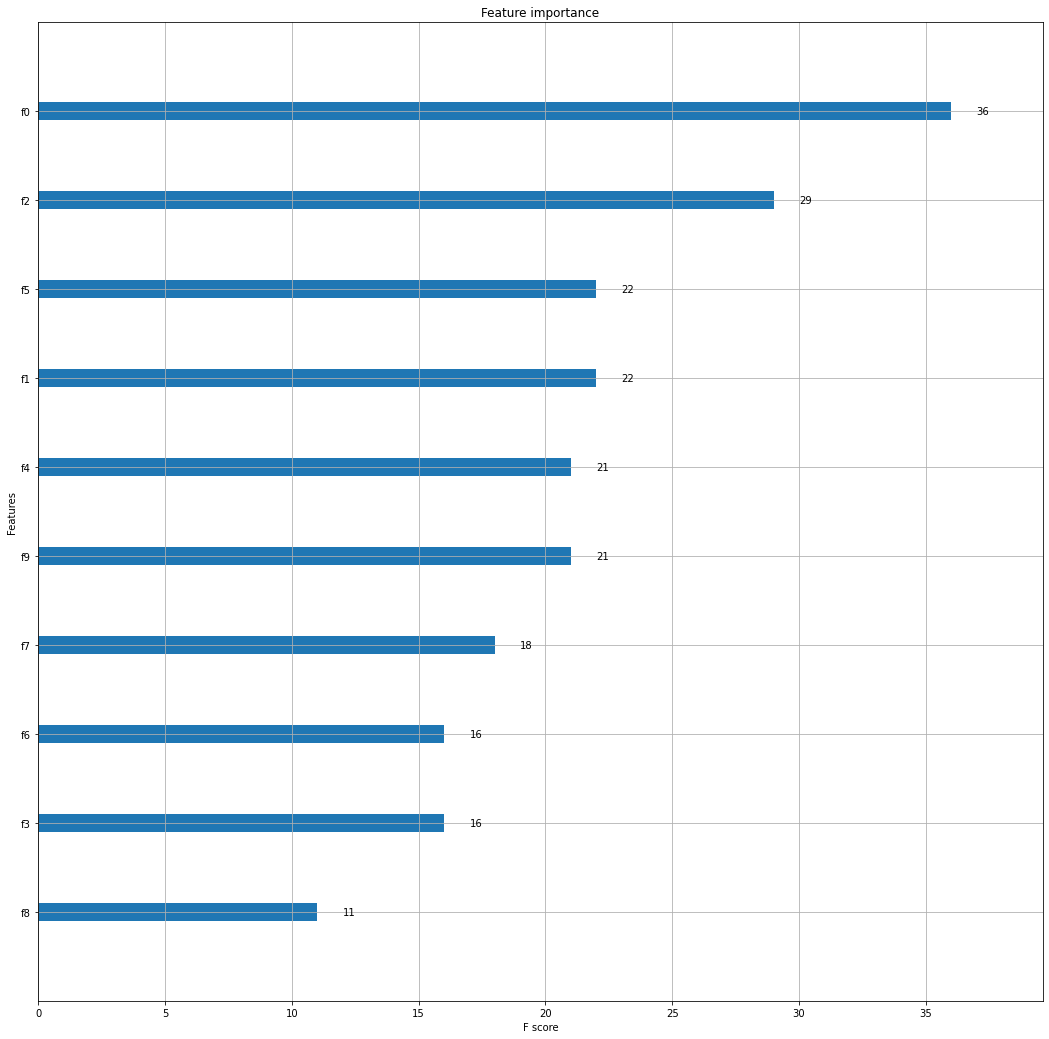

[20:31:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
---The metric scores of the test set is---
Precision = 0.491,Recall = 0.368, F_score = 0.478
--- 206.79575300216675 seconds ---


In [127]:
model_train(pipe,param_grid,n_iter,X_train,y_train,target_train,X_cv,y_cv,target_cv,X_val,y_val,target_val,X_test,y_test,target_test,plot_fea = True)

In [ ]:
param_grid = {
    'criterion':['gini','entropy'],
    'min_samples_split':[2,3,5,6,8,10,12],
    'bootstrap': [True],
    'max_depth': [i for i in range(1,6)],
    'max_features': [i for i in range(6,12)],
    'min_samples_leaf': [3,4,5,6,7],
    'min_samples_split': [2,3,5,6],
    'n_estimators': [300,500,800],
    "class_weight":["balanced","balanced_subsample"]
}

clf_3 = RandomForestClassifier()


In [ ]:
rdmsearch.fit(X_cv, target_cv)

In [95]:
prob_val = np.array(rdmsearch.predict_proba(X_val)[:,1])

interval = 0.2/10000
threshold = [0.4 + i*interval for i in range(10001)]

frame = pd.DataFrame()

for i in threshold:    
    scores_cla = [1 if j > i else 0 for j in prob_val]

    scores_val = list(scores_cla)
    label_val = list(target_val)

    cl = stats_met(label_val,scores_val)

    precision = cl.precision()

    recall = cl.recall()

    f_beta = cl.f_beta(beta = 0.3)

    frame_row = {"threshold":i,"Precision":precision,"Recall":recall,"F_beta":f_beta}
    frame = frame.append(frame_row,ignore_index=True)


threshold_max = frame.loc[frame.F_beta == max(frame.F_beta),"threshold"].iloc[0]

scores_val = [1 if j > threshold_max else 0 for j in prob_val]


In [97]:
threshold_max

0.49602

In [98]:
rdmsearch.fit(X_train, target_train)

[17:29:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { n_estimatorsf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:29:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('pca', PCA()),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interaction_constraints=None,
  

In [103]:
pred_prob = list(rdmsearch.predict_proba(X_test)[:,1])

In [104]:
scores = [1 if j > threshold_max else 0 for j in pred_prob]

In [105]:
labels = list(target_test)

In [106]:
stats_met(labels,scores).get_eval_metrics()

Precision = 0.483,Recall = 0.347, F_score = 0.468
